<a href="https://colab.research.google.com/github/nem-42098/SL_Proj_Unlearning/blob/main/Unlearn_test_FM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/nem-42098/SL_Proj_Unlearning.git
import os
os.chdir('/content/SL_Proj_Unlearning')

fatal: destination path 'SL_Proj_Unlearning' already exists and is not an empty directory.


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from torch.nn import Module
from torch.nn import CrossEntropyLoss,Softmax
from torch.utils.data import DataLoader,Dataset
from itertools import chain
import numpy as np
from tqdm import tqdm as tq

### Load Pre-Trained VGG network
> #### https://github.com/chenyaofo
> ### Note: There is some issue with using Batch Norm before ReLu as it creates a bias in the network. So people exchange the order between the two for tackling the bias

In [3]:
### First time when you wan to download the model
device=torch.device('cuda')
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg11_bn", pretrained=True)
model
# model=model.to(device)
### For future uses:Loading from the local

# model_1=torch.hub.load("C:/Users/nmura/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master",'hubconf.py',source='local')



Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### Check which pre-trained model are available:

In [4]:
torch.hub.list("chenyaofo/pytorch-cifar-models", force_reload=True)

Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip


['cifar100_mobilenetv2_x0_5',
 'cifar100_mobilenetv2_x0_75',
 'cifar100_mobilenetv2_x1_0',
 'cifar100_mobilenetv2_x1_4',
 'cifar100_repvgg_a0',
 'cifar100_repvgg_a1',
 'cifar100_repvgg_a2',
 'cifar100_resnet20',
 'cifar100_resnet32',
 'cifar100_resnet44',
 'cifar100_resnet56',
 'cifar100_shufflenetv2_x0_5',
 'cifar100_shufflenetv2_x1_0',
 'cifar100_shufflenetv2_x1_5',
 'cifar100_shufflenetv2_x2_0',
 'cifar100_vgg11_bn',
 'cifar100_vgg13_bn',
 'cifar100_vgg16_bn',
 'cifar100_vgg19_bn',
 'cifar100_vit_b16',
 'cifar100_vit_b32',
 'cifar100_vit_h14',
 'cifar100_vit_l16',
 'cifar100_vit_l32',
 'cifar10_mobilenetv2_x0_5',
 'cifar10_mobilenetv2_x0_75',
 'cifar10_mobilenetv2_x1_0',
 'cifar10_mobilenetv2_x1_4',
 'cifar10_repvgg_a0',
 'cifar10_repvgg_a1',
 'cifar10_repvgg_a2',
 'cifar10_resnet20',
 'cifar10_resnet32',
 'cifar10_resnet44',
 'cifar10_resnet56',
 'cifar10_shufflenetv2_x0_5',
 'cifar10_shufflenetv2_x1_0',
 'cifar10_shufflenetv2_x1_5',
 'cifar10_shufflenetv2_x2_0',
 'cifar10_vgg11_bn

### Downlaoding the Dataset and Creating the Dataloaders

In [5]:
### Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
    )
])
### Pytorch Datasets
train_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = True,
    download =True, transform = transform)
test_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = transform)
### Dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
len(train_dataset)

50000

### Create the Syntheic Dataset
> ### There is parameter equivalent to Noise which informs me about the percentage of the samples whose labels would be randomly generated

In [7]:
# # Define the classes
# classes = ['forget', 'retain']

# # Create a dictionary to store datasets for each class
# class_datasets = {class_name: [] for class_name in classes}

# # Iterate through the CIFAR-10 dataset and split it into class-specific subsets
# for image, label in train_dataset:
#   if label == 1:
#     class_datasets['forget'].append((image, label))

#   else:
#       class_datasets['retain'].append((image, label))

# # You now have class-specific subsets in the class_datasets dict
import random
torch.manual_seed(0)

# Define the percentage of samples to shuffle labels
shuffle_percentage = 0.2  # Change this value as needed

# Calculate the number of samples to shuffle
num_samples_to_shuffle = int(shuffle_percentage * len(train_dataset))

# Create a copy of the original dataset
synthetic_dataset = deepcopy(train_dataset)

# Shuffle the labels of a subset of samples
indices_to_shuffle = torch.randperm(len(train_dataset))[:num_samples_to_shuffle]
for idx in indices_to_shuffle:
    current_label = train_dataset[idx][1]  # Get the original label
    # Choose a new label randomly (excluding the original label)
    new_label = torch.randint(0, 10, (1,)).item()
    print(new_label)
    while new_label == current_label:
        new_label = torch.randint(0, 10, (1,)).item()
    # Update the label in the synthetic dataset
    synthetic_dataset.targets[idx] = new_label



Streaming output truncated to the last 5000 lines.
9
5
8
6
3
7
4
1
9
1
9
8
6
4
5
3
4
4
6
0
8
1
4
1
9
9
0
8
2
0
2
5
2
9
7
4
1
8
2
8
9
1
8
6
2
8
1
6
4
6
9
4
9
8
4
7
1
4
0
3
3
2
6
6
2
7
5
1
4
9
0
2
5
4
9
1
5
7
6
4
6
7
1
9
2
4
9
2
1
8
5
5
8
6
7
6
0
6
9
4
1
9
6
8
0
4
8
2
5
0
8
0
9
4
4
6
1
1
1
8
7
7
8
3
9
8
4
8
5
9
8
3
5
2
5
9
5
9
6
9
0
9
1
3
4
9
3
5
3
8
5
2
3
2
3
2
4
9
4
3
0
7
0
7
1
0
4
5
9
5
9
4
8
4
0
2
8
3
9
7
5
4
4
3
4
3
9
3
0
7
7
3
7
4
9
8
6
1
9
7
3
5
4
1
6
3
9
4
7
6
9
1
2
9
7
8
4
0
9
9
5
3
8
7
0
6
1
9
9
4
5
2
3
1
8
0
5
4
0
3
7
0
8
8
1
9
9
6
3
6
3
9
9
4
7
9
5
2
5
9
4
2
3
7
3
5
0
6
1
8
7
7
9
4
9
8
2
5
2
8
4
2
0
9
0
6
0
8
5
8
7
9
8
2
5
6
8
4
5
7
6
8
6
3
8
1
3
3
9
6
3
7
7
6
8
7
6
5
1
9
8
6
2
7
1
4
3
8
4
4
5
0
2
7
1
0
1
0
7
4
2
4
8
4
9
2
6
1
5
8
4
8
1
0
4
1
8
7
1
7
5
5
9
7
3
2
6
4
8
4
3
9
5
5
6
2
5
2
9
2
3
2
5
6
1
0
6
4
6
3
7
3
2
5
7
2
7
5
4
9
7
6
4
5
9
5
7
7
6
1
3
1
1
9
3
3
8
8
4
2
1
1
6
4
2
4
8
9
1
8
9
2
7
6
4
0
8
4
8
8
4
7
9
1
6
8
4
3
9
6
1
5
1
4
6
9
8
1
1
8
0
1
3
5
8
9
6
3
1
6
3
3
7
5
6

In [8]:
### Congiguration file taken
config={'max_epochs': 120,

                     'data':
                      [('type_', 'cifar100'),
                                  ('image_size', 32),
                                  ('num_classes', 100),
                                  ('root', 'data/cifar100'),
                                  ('mean', [0.507, 0.4865, 0.4409]),
                                  ('std', [0.2673, 0.2564, 0.2761]),
                                  ('batch_size', 256),
                                  ('num_workers', 4)],
                     'model':[('type_', 'PyTorchHub'),
                                  ('force_reload', False),
                                  ('repo', 'chenyaofo/pytorch-cifar-models'),
                                  ('name', 'cifar100_vgg11_bn'),
                                  ('pretrained', False)],
                     'optimizer':
                      [('type_', 'SGD'),
                                  ('lr', 0.1),
                                  ('momentum', 0.9),
                                  ('dampening', 0),
                                  ('weight_decay', 0.0005),
                                  ('nesterov', True)],
                     'scheduler':
                      [('type_', 'CosineAnnealingLR'),
                                  ('T_max', 200),
                                  ('eta_min', 0)],
                     }

In [9]:
def init_weights(layer: Module) -> None:
        """
        reset_parameters = getattr(layer, "reset_parameters", None)
        if callable(reset_parameters):
            layer.reset_parameters()
        if isinstance(layer, nn.BatchNorm2d):
            # Reset BatchNorm parameters (gamma and beta)
            nn.init.ones_(layer.weight)  # Adjust 'a' and 'b' as needed
            nn.init.zeros_(layer.bias)
            # Reset BatchNorm running statistics (mean and variance)
            layer.reset_running_stats()
            return

        if hasattr(layer, 'bias') and layer.bias is not None:
            nn.init.zeros_(layer.bias)
        if hasattr(layer, 'weight'):
            nn.init.xavier_normal_(layer.weight, 1)
        """
        if isinstance(layer, nn.Conv2d):
            nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)
        elif isinstance(layer, nn.BatchNorm2d):
            nn.init.constant_(layer.weight, 1)
            nn.init.constant_(layer.bias, 0)
        elif isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight, 0, 0.01)

In [10]:
def reset_weights(model: Module,device='cuda') -> Module:
        dumb_model = deepcopy(model)
        dumb_model = dumb_model.apply(init_weights)
        return dumb_model.to(device)

In [11]:
def train_VGG(model:Module,train_dataset:Dataset,config:dict,device:str):

    model=reset_weights(model)
    ### intialising the optimiser
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=0.0001) #torch.optim.SGD(model.parameters(), lr=config['optimizer'][2][1],weight_decay=config['optimizer'][-2][1],momentum=config['optimizer'][2][1],dampening=config['optimizer'][3][1])
    ### intialiasing the scheuler
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=config['scheduler'][1][1],eta_min=config['scheduler'][2][1])
    ### Number of the epochs
    epochs=config['max_epochs']
    ## Train dataloader
    train_dataloader_syn=DataLoader(train_dataset, batch_size=config['data'][-2][1], shuffle=True, num_workers=2)
    ### early stopping counter
    stop_counter = 0
    ## criterion
    criterion=CrossEntropyLoss()

    ### Epoch Log of losses
    epoch_log=[]



    ###Iterations
    for epoch in tq(range(epochs)):
        ### iterate over the forget_dataloader
        ### batch _loss
        loss_epoch = 0

        model.train()

        for i, (inputs, targets) in enumerate(train_dataloader_syn):


            ### GPU push
            inputs, targets = inputs.to(
                device), targets.to(device)

            if next(model.parameters()).is_cuda:
                    pass
                    # print("Model is on CUDA (GPU)")
            else:
                    model=model.to(device)


            ### predictions from the model
            y_pred = model(inputs)

            optimizer.zero_grad()

            ###Calculate the Loss

            loss = criterion(y_pred, targets)

            ## Backpropogate the Loss
            loss.backward()
            ### Update the weights
            optimizer.step()

            #### Train-set loss
            loss_epoch += loss.item()

        loss_epoch /= (i + 1)

        ### Check for early stopping: if the decrease in the loss is less than 1e-3 for straight 5 iterations

        if epoch > 0:
            if abs(epoch_log[-1][0] - loss_epoch) < 1e-3:

                print('increaing the counter',epoch_log[-1][0] - loss_epoch)
                stop_counter += 1

            else:
                stop_counter = 0


        # print(loss_epoch)
        if epoch%5==0:
          acc_1=test(model,train_dataloader_syn,'cuda')
          acc_2=test(model,trainloader,'cuda')
          epoch_log.append([loss_epoch,acc_1,acc_2])
          sns.lineplot(pd.DataFrame(epoch_log))
          plt.show()
        if stop_counter == 5:

            break

    return model,epoch_log


In [12]:
def test(model, dataloader,device):
        model.eval()
        tp, n = 0,0
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)

            with torch.no_grad():
                y_pred = model(X)

            tp += (y_pred.argmax(axis=1) == y).sum().item()
            n  += y.size(0)

        return tp/n

In [13]:
# noisy_model,epoch_log=train_VGG(model,synthetic_dataset,config,'cuda')

In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

In [15]:
# torch.save(noisy_model.state_dict(), 'model_noisy.pt')
# from shutil import copyfile
# copyfile('model_noisy.pt', '/content/drive/My Drive/model_noisy.pt')

In [16]:
noisy_model_state_dict=torch.load('/content/drive/My Drive/model_noisy.pt')

In [17]:
noisy_model=reset_weights(model)
noisy_model.load_state_dict(noisy_model_state_dict)

<All keys matched successfully>

In [18]:
train_dataloader_syn=DataLoader(synthetic_dataset, batch_size=config['data'][-2][1], shuffle=True, num_workers=2)

test(noisy_model,train_dataloader_syn,'cuda')

0.98168

In [19]:
test(noisy_model,trainloader,'cuda')

0.79182

In [20]:
test(noisy_model,testloader,'cuda')

0.6674

### Create the noisy Dataset

In [21]:
noise_index=[]
retain_index=[]
for idx,i in enumerate(train_dataset):

  if i[1] != synthetic_dataset[idx][1]:
    noise_index.append(idx)
  else:
    retain_index.append(idx)


In [22]:
forget_dataset=torch.utils.data.Subset(synthetic_dataset,noise_index)
forget_dataloader=DataLoader(forget_dataset,batch_size=256,shuffle=True,num_workers=2)
correct_noisy_data=torch.utils.data.Subset(train_dataset,noise_index)

correct_noisy_dataloader=DataLoader(correct_noisy_data,batch_size=256,shuffle=True,num_workers=2)

retain_dataset=torch.utils.data.Subset(train_dataset,retain_index)
retain_dataloader=DataLoader(retain_dataset,batch_size=256,shuffle=True,num_workers=2)

### Noisy models learns the noisy data points

In [23]:
test(noisy_model,forget_dataloader,'cuda')

0.964

In [24]:
test(noisy_model,correct_noisy_dataloader,'cuda')

0.0147

In [25]:
from SL_Proj_Unlearning.tools.Unlearner_FM import Unlearner_FM

r_perf_1=[]

R=list(np.linspace(0.001,0.01,10))
R+=list(np.linspace(0.01,0.1,10))
R+=[0.2,0.4,0.6]
forget_path='./forget_hess_cifar10_vgg11_random_samples.pt'
retain_path='./retain_hess_cifar10_vgg11_random_samples.pt'
for i in R:
    # model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg11_bn", pretrained=True)
    torch.cuda.empty_cache()
    unlearner = Unlearner_FM(i,noisy_model, lr = 1e-3)
    ### Getting the new model masked model

    new_model_1, mask_index_1,num_of_param_1=unlearner.Fisher_Masking(retain_dataloader,forget_dataloader,forget_hess_path=forget_path,retain_hess_path=retain_path)

    new_model_1,epoch_log=unlearner.fine_tune(new_model_1,retain_dataloader,30)
    forget_perf=Unlearner_FM.test(new_model_1,forget_dataloader,'cuda')
    retain_perf=Unlearner_FM.test(new_model_1,retain_dataloader,'cuda')
    correct_perf=Unlearner_FM.test(new_model_1,correct_noisy_dataloader,'cuda')
    test_perf=Unlearner_FM.test(new_model_1,testloader,'cuda')

    r_perf_1.append([forget_perf,retain_perf,test_perf,correct_perf,[epoch_log]])
    print(i,forget_perf,retain_perf,test_perf,correct_perf)


Total Number of Kernels and Neurons:1553600, Number of masked Paramters:1553


100%|██████████| 30/30 [06:13<00:00, 12.44s/it]


0.001 0.0308 0.9294 0.7286 0.7273
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:3107


100%|██████████| 30/30 [06:17<00:00, 12.59s/it]


0.002 0.0288 0.965075 0.7495 0.7484
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:4660


100%|██████████| 30/30 [06:11<00:00, 12.40s/it]


0.003 0.0275 0.956675 0.74 0.7411
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:6214


100%|██████████| 30/30 [06:11<00:00, 12.39s/it]


0.004 0.0303 0.953875 0.7398 0.7439
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:7768


100%|██████████| 30/30 [06:08<00:00, 12.29s/it]


0.005 0.0295 0.97305 0.7469 0.7503
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:9321


100%|██████████| 30/30 [06:08<00:00, 12.30s/it]


0.006 0.0277 0.9295 0.7173 0.7248
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:10875


100%|██████████| 30/30 [06:12<00:00, 12.40s/it]


0.007 0.0319 0.928475 0.706 0.7151
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:12428


100%|██████████| 30/30 [06:11<00:00, 12.37s/it]


0.008 0.0287 0.940875 0.736 0.733
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:13982


100%|██████████| 30/30 [06:15<00:00, 12.51s/it]


0.009000000000000001 0.0339 0.927025 0.6975 0.704
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:15536


100%|██████████| 30/30 [06:10<00:00, 12.35s/it]


0.01 0.0339 0.9134 0.6983 0.7061
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:15536


100%|██████████| 30/30 [06:14<00:00, 12.50s/it]


0.01 0.0331 0.930825 0.7007 0.7089
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:31072


100%|██████████| 30/30 [06:10<00:00, 12.35s/it]


0.020000000000000004 0.0358 0.899575 0.6982 0.6978
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:46608


100%|██████████| 30/30 [06:08<00:00, 12.29s/it]


0.030000000000000006 0.0356 0.871975 0.708 0.7144
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:62144


100%|██████████| 30/30 [06:05<00:00, 12.19s/it]


0.04000000000000001 0.0359 0.840275 0.6825 0.6853
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:77680


100%|██████████| 30/30 [06:03<00:00, 12.10s/it]


0.05000000000000001 0.0305 0.861275 0.7142 0.7198
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:93216


 20%|██        | 6/30 [01:24<05:38, 14.09s/it]


0.06000000000000001 0.1039 0.100675 0.1 0.0973
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:108752


 20%|██        | 6/30 [01:24<05:38, 14.10s/it]


0.07 0.103 0.1004 0.1 0.0984
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:124288


 20%|██        | 6/30 [01:26<05:46, 14.44s/it]


0.08 0.1002 0.10015 0.1 0.0994
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:139824


 20%|██        | 6/30 [01:24<05:39, 14.13s/it]


0.09000000000000001 0.103 0.1004 0.1 0.0984
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:155360


 20%|██        | 6/30 [01:26<05:45, 14.41s/it]


0.1 0.1039 0.100675 0.1 0.0973
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:310720


 17%|█▋        | 5/30 [01:12<06:02, 14.51s/it]


0.2 0.103 0.1004 0.1 0.0984
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:621440


 17%|█▋        | 5/30 [01:26<07:11, 17.25s/it]


0.4 0.0975 0.1007 0.1 0.0972
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:932160


 17%|█▋        | 5/30 [01:14<06:13, 14.93s/it]


0.6 0.1047 0.100175 0.1 0.0993


In [26]:
torch.save(r_perf_1, 'model_FM_unlearning_random_samples.pt')
from shutil import copyfile
copyfile('model_FM_unlearning_random_samples.pt', '/content/drive/My Drive/model_FM_unlearning_random_samples.pt')

'/content/drive/My Drive/model_FM_unlearning_random_samples.pt'

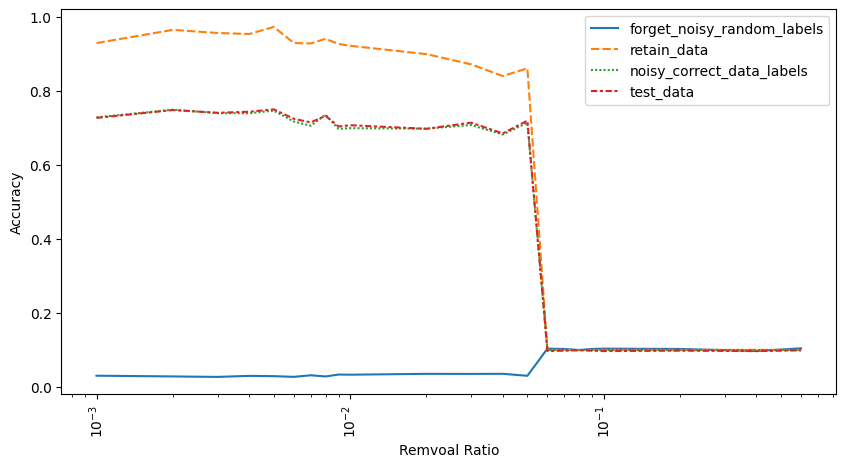

In [29]:
plt.figure(figsize=(10,5))
df =pd.DataFrame(r_perf_1)
R_=[ round(i,3) for i in R ]
df.index=[ i for i in R_]
df.columns=['forget_noisy_random_labels','retain_data','noisy_correct_data_labels','test_data','epch_log']
sns.lineplot(data=df.iloc[:,0:4])
plt.xscale('log')
plt.xticks(rotation=90)
plt.xlabel('Remvoal Ratio')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Forget and Retain

In [ ]:
# Class split
retain_dataloader = torch.utils.data.DataLoader(class_datasets['retain'], batch_size=128, shuffle=True, num_workers=2)
forget_dataloader = torch.utils.data.DataLoader(class_datasets['forget'], batch_size=128, shuffle=True, num_workers=2)

# Random split
# train_split_dataset,forget_split_dataset=torch.utils.data.random_split(train_dataset,lengths=[45000,5000])
# retain_dataloader = torch.utils.data.DataLoader(train_split_dataset,  batch_size=128, shuffle=True, num_workers=2)
# forget_dataloader = torch.utils.data.DataLoader(forget_split_dataset, batch_size=128, shuffle=True, num_workers=2)

# Unlearner class


### Using the Lower precision based model.
> ### There is some problems with this method. Because the counterpart gives better result.

In [ ]:
from tools.Unlearner_FM_precision import Unlearner_FM_precision
r_perf=[]

R=list(np.linspace(0.001,0.1,10))
R+=list(np.linspace(0.01,0.1,10))
R+=[0.2,0.4,0.6]
for i in R:
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg11_bn", pretrained=True)
    torch.cuda.empty_cache()
    unlearner = Unlearner_FM_precision(i,model, lr = 1e-6)
    ### Getting the new model masked model

    new_model, mask_index,num_of_param=unlearner.Fisher_Masking(retain_dataloader,forget_dataloader)

    forget_perf=Unlearner_FM_precision.test(new_model,forget_dataloader,'cuda')
    retain_perf=Unlearner_FM_precision.test(new_model,retain_dataloader,'cuda')
    test_perf=Unlearner_FM_precision.test(new_model,testloader,'cuda')

    r_perf.append([forget_perf,retain_perf,test_perf])




Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:1553


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:18643


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:35732


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:52822


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:69912


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:87001


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:104091


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:121180


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:138270


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:155360


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:15536


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:31072


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:46608


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:62144


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:77680


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:93216


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:108752


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:124288


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:139824


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:155360


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:310720


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:621440


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:932160


In [ ]:
r_perf

[[0.99, 0.9992444444444445, 0.9174],
 [0.9934, 0.9991111111111111, 0.9178],
 [0.9882, 0.9975777777777778, 0.9115],
 [0.9708, 0.9993111111111111, 0.9138],
 [0.9952, 0.9982888888888889, 0.9144],
 [0.9922, 0.9974222222222222, 0.9111],
 [0.991, 0.9951111111111111, 0.9068],
 [0.9924, 0.9943555555555555, 0.905],
 [0.9806, 0.9931333333333333, 0.9031],
 [0.9854, 0.9922222222222222, 0.9031],
 [0.9954, 0.9993333333333333, 0.9183],
 [0.9812, 0.9956888888888888, 0.9092],
 [0.9872, 0.9987777777777778, 0.9155],
 [0.9956, 0.9985111111111111, 0.9162],
 [0.9908, 0.9981333333333333, 0.9132],
 [0.9782, 0.9747333333333333, 0.8839],
 [0.991, 0.9957777777777778, 0.9076],
 [0.9952, 0.9934888888888889, 0.9071],
 [0.9852, 0.9915333333333334, 0.9011],
 [0.9944, 0.9938444444444444, 0.9056],
 [0.1416, 0.8173333333333334, 0.6768],
 [0.0, 0.1111111111111111, 0.1],
 [0.0, 0.1111111111111111, 0.1]]

In [ ]:
r_perf

[[0.1822, 0.565, 0.4987],
 [0.9948, 0.9994666666666666, 0.9186],
 [0.9908, 0.9979333333333333, 0.9122],
 [0.9624, 0.9833111111111111, 0.892],
 [0.9408, 0.9732222222222222, 0.8727],
 [0.6086, 0.8173333333333334, 0.7206]]

### Counterpart: Maintaining the original precision of the model and diverting some operation to CPU.

In [ ]:
# from tools.Unlearner_FM import Unlearner_FM
# torch.cuda.empty_cache()
# model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg11_bn", pretrained=True)
# unlearner_1 = Unlearner_FM(0.02,model, lr = 1e-6)


from tools.Unlearner_FM import Unlearner_FM
r_perf_1=[]

R=list(np.linspace(0.001,0.01,10))
R+=list(np.linspace(0.01,0.1,10))
R+=[0.2,0.4,0.6]
forget_path='./data/forget_hess_cifar10_vgg11_class1.pt'
retain_path='./data/retain_hess_cifar10_vgg11_class1.pt'
for i in R:
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg11_bn", pretrained=True)
    torch.cuda.empty_cache()
    unlearner = Unlearner_FM(i,model, lr = 1e-6)
    ### Getting the new model masked model

    new_model_1, mask_index_1,num_of_param_1=unlearner.Fisher_Masking(retain_dataloader,forget_dataloader,forget_hess_path=forget_path,retain_hess_path=retain_path)


    forget_perf=Unlearner_FM.test(new_model_1,forget_dataloader,'cuda')
    retain_perf=Unlearner_FM.test(new_model_1,retain_dataloader,'cuda')
    test_perf=Unlearner_FM.test(new_model_1,testloader,'cuda')

    r_perf_1.append([forget_perf,retain_perf,test_perf])



Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:1553600, Number of masked Paramters:1553


KeyboardInterrupt: 

In [ ]:
R_=[ round(i,3) for i in R ]

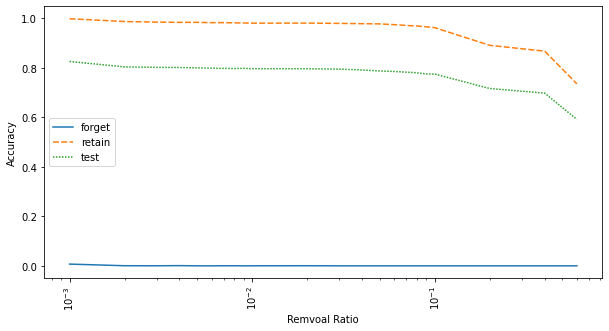

In [ ]:
plt.figure(figsize=(10,5))
df =pd.DataFrame(r_perf_1)
df.index=[ i for i in R_]
df.columns=['forget','retain','test']
sns.lineplot(data=df)
plt.xscale('log')
plt.xticks(rotation=90)
plt.xlabel('Remvoal Ratio')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
r_perf_1

[[0.007, 0.9988222222222222, 0.8262],
 [0.0004, 0.9875777777777778, 0.8041],
 [0.0002, 0.9852, 0.8024],
 [0.0008, 0.9841555555555556, 0.8016],
 [0.0, 0.9842666666666666, 0.8005],
 [0.0, 0.9830888888888889, 0.7989],
 [0.0002, 0.9830444444444445, 0.7983],
 [0.0002, 0.9821777777777778, 0.7975],
 [0.0, 0.9818222222222223, 0.7985],
 [0.0002, 0.9808, 0.7968],
 [0.0, 0.9809111111111111, 0.7969],
 [0.0004, 0.9811777777777778, 0.7967],
 [0.0, 0.9799555555555556, 0.7952],
 [0.0, 0.9788444444444444, 0.7918],
 [0.0, 0.9779111111111111, 0.7876],
 [0.0, 0.9748888888888889, 0.7857],
 [0.0, 0.9716, 0.7828],
 [0.0, 0.9694222222222222, 0.7803],
 [0.0, 0.9661555555555555, 0.7755],
 [0.0, 0.9627111111111111, 0.7752],
 [0.0, 0.8913555555555556, 0.7168],
 [0.0, 0.8678, 0.6981],
 [0.0, 0.7358, 0.5921]]

In [ ]:
from tools.Unlearner_FM import Unlearner_FM
r_perf_2=[]

R=list(np.linspace(0.001,0.01,10))
R+=list(np.linspace(0.01,0.1,10))
R+=[0.2,0.4,0.6]
forget_path='./data/forget_hess_cifar10_vgg11_class1.pt'
retain_path='./data/retain_hess_cifar10_vgg11_class1.pt'
for i in R:
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg11_bn", pretrained=True)
    torch.cuda.empty_cache()
    unlearner = Unlearner_FM(i,model, lr = 1e-6)
    ### Getting the new model masked model

    new_model_1, mask_index_1,num_of_param_1=unlearner.Fisher_Masking(retain_dataloader,forget_dataloader,forget_hess_path=forget_path,retain_hess_path=retain_path)

    new_model_1,epoch_log=unlearner.fine_tune(new_model_1,retain_dataloader)
    forget_perf=Unlearner_FM.test(new_model_1,forget_dataloader,'cuda')
    retain_perf=Unlearner_FM.test(new_model_1,retain_dataloader,'cuda')
    test_perf=Unlearner_FM.test(new_model_1,testloader,'cuda')

    r_perf_2.append([forget_perf,retain_perf,test_perf,[epoch_log]])


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:1553600, Number of masked Paramters:1553


 10%|█         | 1/10 [01:03<09:29, 63.30s/it]


KeyboardInterrupt: 

: 

## Run the unlearning


In [ ]:
### Getting the new model masked model

new_model_1, mask_index_1,num_of_param_1=unlearner_1.Fisher_Masking(retain_dataloader,forget_dataloader)

Finished Computing Hessian Diagonal
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:31072


In [ ]:
Unlearner_FM.test(new_model_1,forget_dataloader,'cuda')

0.0

In [ ]:
Unlearner_FM.test(new_model_1,retain_dataloader,'cuda')

0.9576666666666667

In [ ]:
Unlearner_FM.test(new_model_1,testloader,'cuda')

0.7854

We can see that the unlearning process may need many epochs in the erasure phase to converge. We could also try to increase the learning rate for faster convergence.

In [ ]:
import pandas as pd
import seaborn as sns

log_df = pd.DataFrame.from_records(unlearner.log, columns=['phase', 'epoch', 'batch', 'tp', 'n', 'loss'])
unlearn_history = log_df.groupby(['phase', 'epoch']).agg({'tp':sum, 'n':sum, 'loss': 'mean'}).reset_index()
unlearn_history['accuracy'] = unlearn_history.tp / unlearn_history.n
unlearn_history.loc[unlearn_history.phase == 'erasure', 'loss_scale'] = unlearn_history.loc[unlearn_history.phase == 'erasure', 'loss'] /unlearn_history.loc[unlearn_history.phase == 'erasure', 'loss'].max()
unlearn_history.loc[unlearn_history.phase == 'retrain', 'loss_scale'] = unlearn_history.loc[unlearn_history.phase == 'retrain', 'loss'] /unlearn_history.loc[unlearn_history.phase == 'retrain', 'loss'].max()

sns.lineplot(data = unlearn_history, x = 'epoch', y='loss_scale', hue='phase')

## Check model performance
We now try check the model performance on the retain and forget set.

In [ ]:
models = {'original':model, 'dumb':unlearner.dumb_model, 'erased':unlearner.erased_model, 'retrained':unlearner.retrained_model}
dataloaders = {'retain':retain_dataloader, 'forget':forget_dataloader, 'test':testloader}

performances = []
for model_name, m in models.items():
  for dl_name, dl in dataloaders.items():
    acc = test(m, dl)
    performances.append((model_name, dl_name, acc))

Strangely the dumb network has 0% performance on the forget set, and this may have a negative impact, note that the performance on the forget set is even too low (we expected 10%, not less).

Outside of that we note that this procedure works great for the retain and test which are fitted very nicely, and we can even see that there's a big leap in performance from the erased model to the retrained model.

In [ ]:
perf_df = pd.DataFrame.from_records(performances, columns=['model', 'data_partition', 'accuracy'])

tb = pd.pivot_table(perf_df, index='data_partition', columns='model', values='accuracy')
sns.heatmap(tb, annot = True, fmt='.2%')